# Import Packages 

In [143]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn_pandas import DataFrameMapper, gen_features
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore')

# Import Data

In [144]:
train = pd.read_csv("train.csv")
x_train = train.drop("Transported", axis = 1).copy()
y_train = train[['Transported']]
test = pd.read_csv("test.csv")

# Data Exploration

In [145]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [146]:
#columns
train.keys()

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [147]:
#summary statistics
perc =[.05, 0.25, 0.50, 0.75, 0.9]
train.describe(percentiles = perc)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
90%,49.000000,753.000000,1026.000000,619.600000,732.000000,732.600000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [148]:
#averages of numerical variables by categorical variables
train.groupby(['HomePlanet', 'Destination','CryoSleep','Transported']).mean()

Age  RoomService  \
HomePlanet Destination   CryoSleep Transported                           
Earth      55 Cancri e   False     False        25.693380   284.230769   
                                   True         22.781421    80.524862   
                         True      False        22.088889     0.000000   
                                   True         20.467532     0.000000   
           PSO J318.5-22 False     False        30.649123   152.048246   
                                   True         27.650943   134.355769   
                         True      False        25.424779     0.000000   
                                   True         23.187234     0.000000   
           TRAPPIST-1e   False     False        28.459333   244.993293   
                                   True         25.937031   108.468468   
                         True      False        23.860000     0.000000   
                                   True         22.673554     0.000000   
Europa     55 Cancri e   False     False        37.459459   388.440154   
                                   True         34.026316    93.175325   
                         True      False        25.000000     0.000000   
                                   True         32.753521     0.000000   
           PSO J318.5-22 False     False        39.800000   626.250000   
                                   True         36.800000    14.200000   
                         True      True         34.222222     0.000000   
           TRAPPIST-1e   False     False        36.434889   326.254950   
                                   True         34.068493   132.938983   
                         True      False        17.875000     0.000000   
                                   True         33.374419     0.000000   
Mars       55 Cancri e   False     False        29.235294  1337.147059   
                                   True         21.952381   491.219512   
                         True      False        31.000000     0.000000   
                                   True         27.959459     0.000000   
           PSO J318.5-22 False     False        35.166667   458.347826   
                                   True         35.166667   605.818182   
                         True      False        31.000000     0.000000   
                                   True         41.333333     0.000000   
           TRAPPIST-1e   False     False        32.079239  1129.161695   
                                   True         23.200000   319.818584   
                         True      False        31.905660     0.000000   
                                   True         28.070994     0.000000   

                                                  FoodCourt  ShoppingMall  \
HomePlanet Destination   CryoSleep Transported                              
Earth      55 Cancri e   False     False         133.195652    133.583630   
                                   True          240.901639    268.609890   
                         True      False           0.000000      0.000000   
                                   True            0.000000      0.000000   
           PSO J318.5-22 False     False         167.122807    134.413043   
                                   True          196.009524    327.858491   
                         True      False           0.000000      0.000000   
                                   True            0.000000      0.000000   
           TRAPPIST-1e   False     False         138.236315    131.253989   
                                   True          346.874622    333.358434   
                         True      False           0.000000      0.000000   
                                   True            0.000000      0.000000   
Europa     55 Cancri e   False     False        2076.888462    174.710938   
                                   True         5597.025806    422.703226   
                         True      False           0.000000      0.000000   
      

### Home Planet 

[Text(0.5, 1.0, 'Home Planet')]

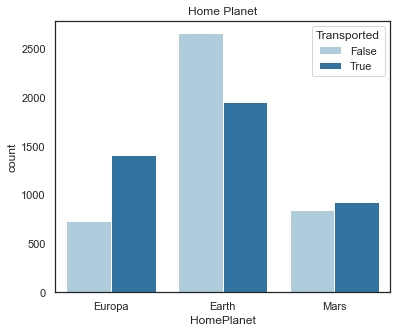

In [149]:
sns.set(rc={"figure.figsize":(6, 5)}) 
sns.set_theme(style="white", palette="Paired")
sns.countplot(data=train, x="HomePlanet", hue="Transported").set(title='Home Planet')

### Cyro Sleep

[Text(0.5, 1.0, 'Cryo Sleep')]

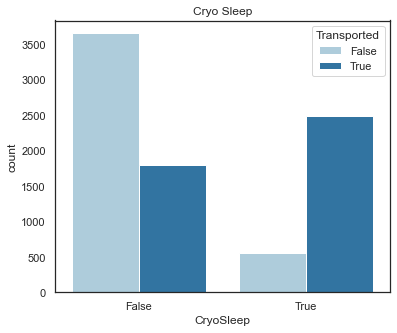

In [150]:
sns.countplot(data=train, x="CryoSleep", hue="Transported").set(title='Cryo Sleep')

### Destination

[Text(0.5, 1.0, 'Destination')]

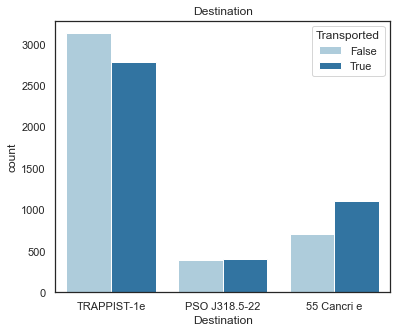

In [151]:
sns.countplot(data=train, x="Destination", hue="Transported").set(title='Destination')

### VIP

[Text(0.5, 1.0, 'VIP')]

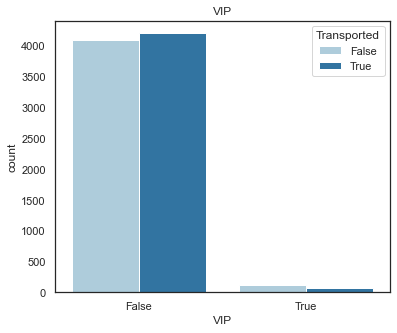

In [152]:
sns.countplot(data=train, x="VIP", hue="Transported").set(title='VIP')

### Age

[Text(0.5, 1.0, 'Age')]

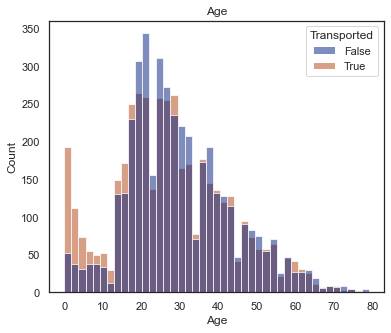

In [153]:
sns.set_theme(style="white", palette="dark")
sns.histplot(data = train,x = 'Age', hue = 'Transported', alpha = 0.5).set(title='Age')

### On Demand Services

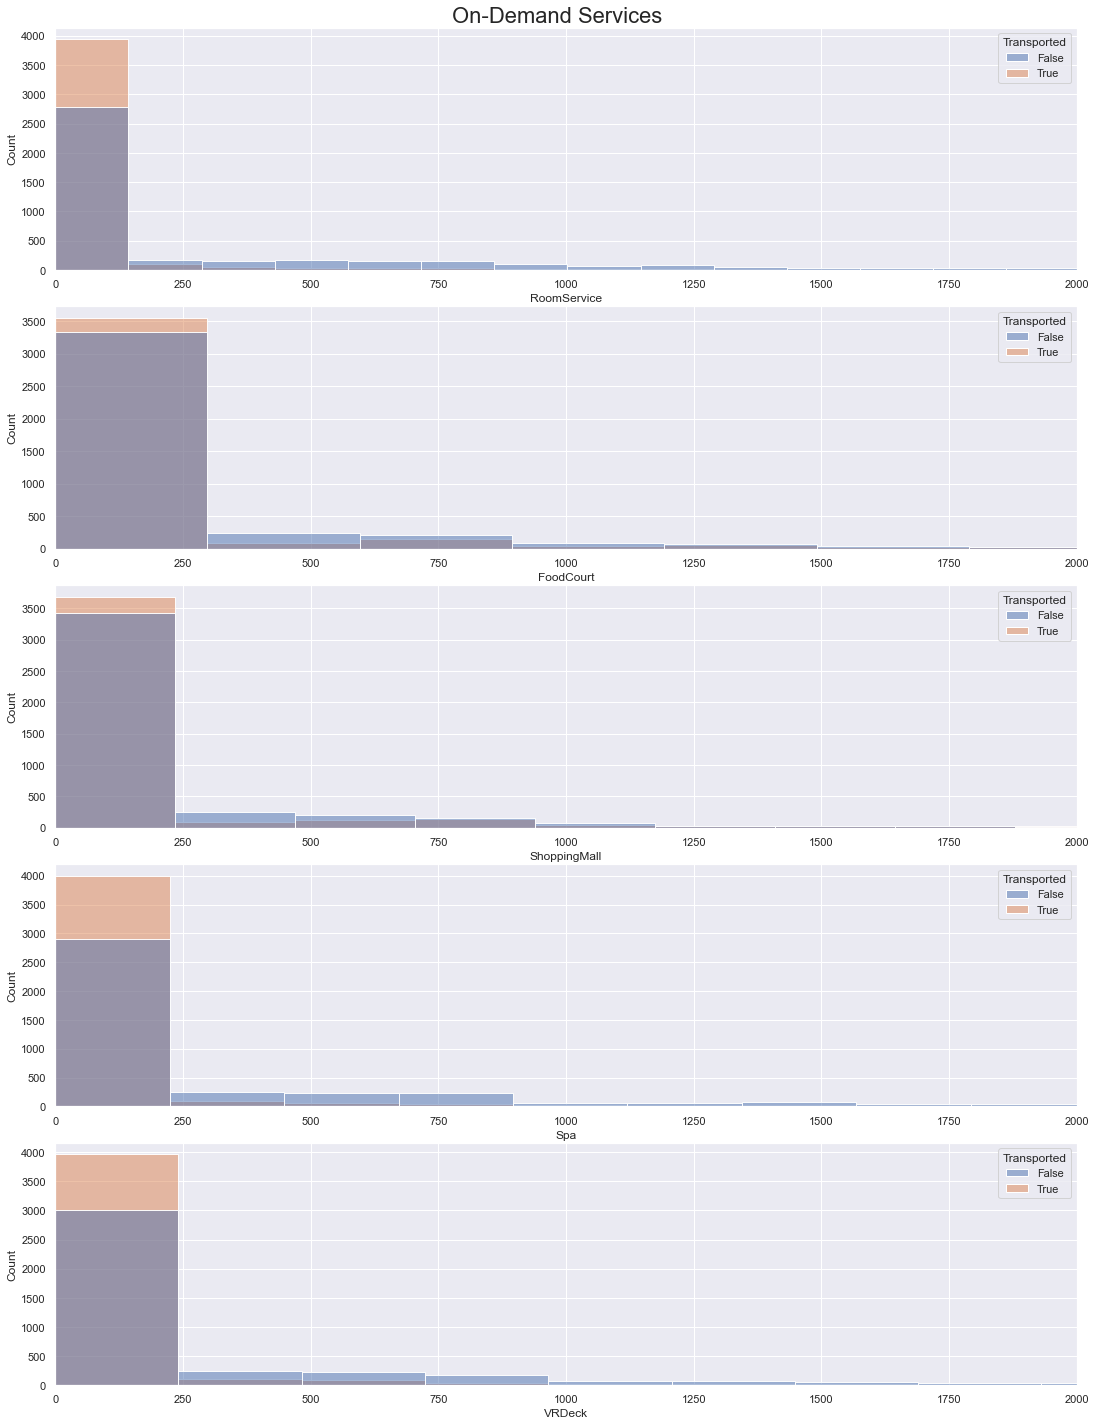

In [154]:
sns.set(rc={"figure.figsize":(15, 20)}) 
fig, axs = plt.subplots(nrows=5)
fig.suptitle('On-Demand Services', fontsize=22)
fig.tight_layout()

for i, service in enumerate(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]):
    services = sns.histplot(data = train,x = service, hue = 'Transported', alpha = 0.5, ax=axs[i], bins=100)
    services.set_xlim(0, 2000)
    plt.show

### Check for Null Values

In [155]:
# check for null values in each column
train.isnull().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

In [156]:
#number of null values in each column
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Correlation

In [157]:
train_corr = train.copy()  
train_corr['Transported'] = train['Transported'].astype(int) 
train_corr.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


# Data Transformation

### Add features

In [158]:
def AddFeatures(X: pd.DataFrame):
    
    #split name and cabin
    df = pd.concat((X[x_train.columns].drop(['Name', 'Cabin'],axis=1),
                X.Name.str.split(' ', expand= True).add_prefix('Name'),
                X.Cabin.str.split('/', expand= True).add_prefix('Cabin')), axis=1)
    
    #fill na in amenities
    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']]=\
    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0.0)
    
    #create total spend
    df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + \
    df['Spa'] + df['VRDeck'];
    
    df['VIP'] = df['VIP']*1.0;
    df['VIP'] = df['VIP'].astype(np.float16)
    
    return df;

In [159]:
def TrtNullAgeCrSlp(df:pd.DataFrame):
    
    # filling nulls in cryosleep based on spending
    df['CryoSleep'] = np.float16(df['CryoSleep']*1.0);
    df.loc[(df.CryoSleep.isna()==True) & (df.TotalSpend == 0.0), ['CryoSleep']] = 1.0;

    df.loc[(df.CryoSleep.isna()==True) & (df['TotalSpend'] > 0.0), ['CryoSleep']] = 0.0;
    df['CryoSleep'] = df['CryoSleep'].astype(np.int8);
    
    # filling median age for nulls
    df['Age'] = df['Age'].fillna(df.Age.median());
    
    # creating column for child
    df['Is_Child'] = np.where(df.Age <= 12, 1,0);
    df['Is_Child'] = df['Is_Child'].astype(np.int8);
    
    df['Age'] = df['Age'].astype(np.int8);
    
    return df;

In [160]:
def CreateJourney(df: pd.DataFrame):
    
    # fill nulls in home planet based on last name
    df = df.merge(df[['Name1', 'HomePlanet']].drop_duplicates().dropna(), 
                 how= 'left',left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'))
    df['HomePlanet'] = df['HomePlanet'].fillna(df.HomePlanet_)
    df['HomePlanet'] = df['HomePlanet'].fillna(df[['HomePlanet']].\
                                               apply(lambda x: x.mode()).values[0][0])

    # fill nulls in destination based on last name 
    _ = df[['Name1', 'Destination']].groupby('Name1')['Destination'].\
    value_counts(ascending= False);
    _.name = 'Nb_Destination';
    _ = _.reset_index().groupby(['Name1']).head(1);

    df = df.merge(_, how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'));
    df['Destination'] = df['Destination'].fillna(df['Destination_']);
    df['Destination'] = df['Destination'].fillna(df[['Destination']].\
                                                 apply(lambda x: x.mode()).values[0][0]);
    del _;

    # journey column from home planet and destination
    df['Journey'] = df['HomePlanet'] + '_' + df['Destination'];
    df = df.drop(['HomePlanet','Destination','HomePlanet_','Destination_','Nb_Destination'], 
                 axis=1,errors = 'ignore');

    return df;

In [161]:
def TrtNullVIPCabin(df: pd.DataFrame):

    # fill nulls by assuming members of the same family have the same VIP ID
    df = df.merge(df[['VIP', 'Name1']].groupby('Name1')['VIP'].max(), 
                how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['VIP'] = df['VIP'].fillna(df.VIP_);
    df['VIP'] = df['VIP'].fillna(0.0);
    df['VIP'] = df['VIP'].astype(np.int8);
 
    # fill nulls by assuming members of the same family have the same cabin ID
    _ = df[['Cabin0', 'Name1']].groupby('Name1')['Cabin0'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    del _;

    _ = df[['Cabin2', 'Name1']].groupby('Name1')['Cabin2'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);

    df = df.drop(['Cabin0_', 'Cabin2_'], axis=1, errors= 'ignore');
    del _;

    # remaining nulls based on VIP status
    df = df.merge(df.groupby(['VIP']).agg({'Cabin0': lambda df: df.mode(), 'Cabin2': lambda y: y.mode()}),
                how= 'left', left_on= 'VIP', right_index= True, suffixes= ('', '_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);
    df = df.drop(['Cabin0_', 'Cabin2_', 'VIP_'], axis=1, errors= 'ignore');
    
    df = df.drop(['Cabin1', 'Name0', 'Name1'], axis=1, errors= 'ignore');
    
    # change to float 16  
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']] = \
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']].astype(np.float16);  
    
    return df;

In [162]:
# training data
Ytrain = np.where(train[['Transported']] == True, 1,0).ravel();
Xtrain = train.drop('Transported', axis=1);

# data transformer pipeline
Data_Xformer=\
Pipeline(steps= 
         [('AddFeatures', FunctionTransformer(AddFeatures)),
          ('TrtNullAgeCrSlp', FunctionTransformer(TrtNullAgeCrSlp)),
          ('CreateJourney', FunctionTransformer(CreateJourney)),
          ('TrtNullVIPCabin', FunctionTransformer(TrtNullVIPCabin)),
          ('LblEncode', DataFrameMapper(input_df= True, df_out= True, drop_cols= ['PassengerId'],default=None,
                                       features=gen_features(columns= [['Journey'], ['Cabin0'], ['Cabin2']],
                                                             classes= [LabelEncoder])
                                       ))
         ], verbose= True)

# implement pipeline on training and test set
Xtrain = Data_Xformer.fit_transform(x_train, Ytrain)
Xtest = Data_Xformer.transform(test)

[Pipeline] ....... (step 1 of 5) Processing AddFeatures, total=   0.1s
[Pipeline] ... (step 2 of 5) Processing TrtNullAgeCrSlp, total=   0.0s
[Pipeline] ..... (step 3 of 5) Processing CreateJourney, total=   0.1s
[Pipeline] ... (step 4 of 5) Processing TrtNullVIPCabin, total=   0.1s
[Pipeline] ......... (step 5 of 5) Processing LblEncode, total=   0.0s


### Correlation

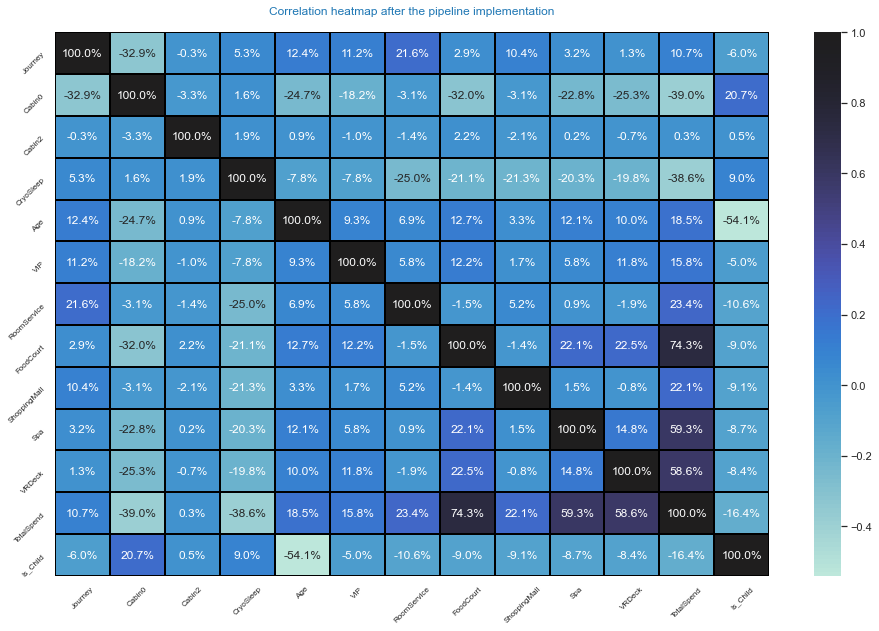

In [163]:
fig, ax= plt.subplots(1,1, figsize= (16,10))
sns.heatmap(Xtrain.corr(), cmap = 'icefire', annot= True, fmt= '.1%', 
            linewidth= 1.0, linecolor= 'black', ax=ax, center= True)
ax.set_title("Correlation heatmap after the pipeline implementation\n", fontsize= 12, color= 'tab:blue')
plt.yticks(rotation= 45, fontsize= 8)
plt.xticks(rotation= 45, fontsize= 8)
plt.show()

# Data Modelling 

### XG Boost 

In [164]:
#create classifier
xgboost_model = XGBClassifier(use_label_encoder = False)

In [165]:
#evaluate using cross validation
cv_results_xg = cross_validate(xgboost_model, Xtrain, Ytrain, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
print (f'Accuracy - : {cv_results_xg["test_accuracy"].mean()}')
print (f'Precision - : {cv_results_xg["test_precision"].mean()}')
print (f'Recall - : {cv_results_xg["test_recall"].mean()}')
print (f'F1 - : {cv_results_xg["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results_xg["test_roc_auc"].mean()}')

Accuracy - : 0.7997300371678373
Precision - : 0.798503190681151
Recall - : 0.8083701660345026
F1 - : 0.8026119095058484
roc_auc_score - : 0.8895396790222033


In [166]:
#set parameters
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

In [167]:
#tune model 
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=10, n_jobs=-1, verbose=True).fit(Xtrain, Ytrain)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [168]:
#best parameters 
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [169]:
#create classifier with best parameters
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_).fit(Xtrain, Ytrain)

In [170]:
cv_results_xg_final = cross_validate(xgboost_final, Xtrain, Ytrain, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
print (f'Accuracy - : {cv_results_xg_final["test_accuracy"].mean()}')
print (f'Precision - : {cv_results_xg_final["test_precision"].mean()}')
print (f'Recall - : {cv_results_xg_final["test_recall"].mean()}')
print (f'F1 - : {cv_results_xg_final["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results_xg_final["test_roc_auc"].mean()}')

Accuracy - : 0.8078978347420076
Precision - : 0.7932154093616719
Recall - : 0.8401147299457697
F1 - : 0.8151401123656594
roc_auc_score - : 0.8915896215684652


### LightGBM

In [171]:
#create classifier 
lgbm_model = LGBMClassifier()

In [172]:
#evaluate using cross validation
cv_results = cross_validate(lgbm_model, Xtrain, Ytrain, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
print (f'Accuracy - : {cv_results_l["test_accuracy"].mean()}')
print (f'Precision - : {cv_results_l["test_precision"].mean()}')
print (f'Recall - : {cv_results_l["test_recall"].mean()}')
print (f'F1 - : {cv_results_l["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results_l["test_roc_auc"].mean()}')

Accuracy - : 0.8012218839312834
Precision - : 0.7927352376661576
Recall - : 0.821379778212655
F1 - : 0.8064612217125153
roc_auc_score - : 0.8899856779283721


In [173]:
#set parameters
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [174]:
#tune parameters 
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=True).fit(Xtrain, Ytrain)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [175]:
#best parameters
lgbm_best_grid.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 100}

In [176]:
#final model with best parameters
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_).fit(Xtrain, Ytrain)

In [177]:
#cross validate final model 
cv_results_flgbm = cross_validate(lgbm_final, Xtrain, Ytrain, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print (f'Accuracy - : {cv_results_flgbm["test_accuracy"].mean()}')
print (f'Precision - : {cv_results_flgbm["test_precision"].mean()}')
print (f'Recall - : {cv_results_flgbm["test_recall"].mean()}')
print (f'F1 - : {cv_results_flgbm["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results_flgbm["test_roc_auc"].mean()}')

Accuracy - : 0.8076671560652354
Precision - : 0.799565110115282
Recall - : 0.8282431062767103
F1 - : 0.812672777484592
roc_auc_score - : 0.8929999653606602


### Logistic Regression

In [178]:
#create model 
log_model = LogisticRegression(max_iter = 2000)

In [179]:
#evaluate using cross validation
cv_results_lg = cross_validate(log_model,
                            Xtrain, Ytrain,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [180]:
#print accuracy measures
print (f'Accuracy - : {cv_results_lg["test_accuracy"].mean()}')
print (f'Precision - : {cv_results_lg["test_precision"].mean()}')
print (f'Recall - : {cv_results_lg["test_recall"].mean()}')
print (f'F1 - : {cv_results_lg["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results_lg["test_roc_auc"].mean()}')

Accuracy - : 0.7897217041651786
Precision - : 0.7815556821586326
Recall - : 0.8115701702140999
F1 - : 0.7952501866671586
roc_auc_score - : 0.8685221619126773


In [184]:
param_grid =  {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }

In [185]:
#set parameters 
best_lg_params = {'C': 0.004832930238571752, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}

In [186]:
#tune parameters
log_best_grid = GridSearchCV(log_model, param_grid, cv=3, n_jobs=-1, verbose=False).fit(Xtrain, Ytrain)

In [187]:
#best parameters
log_best_grid.best_params_

{'C': 0.012742749857031334,
 'max_iter': 2500,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [188]:
#final model 
log_model_final = log_model.set_params(**log_best_grid.best_params_).fit(Xtrain,Ytrain)

In [189]:
#evaluate using cross validation
cv_results = cross_validate(log_model_final,
                            Xtrain, Ytrain,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [190]:
#print accuracy measures
print (f'Accuracy - : {cv_results["test_accuracy"].mean()}')
print (f'Precision - : {cv_results["test_precision"].mean()}')
print (f'Recall - : {cv_results["test_recall"].mean()}')
print (f'F1 - : {cv_results["test_f1"].mean()}')
print (f'roc_auc_score - : {cv_results["test_roc_auc"].mean()}')

Accuracy - : 0.789950795603349
Precision - : 0.7678623896558092
Recall - : 0.8389742223336782
F1 - : 0.8009098219158629
roc_auc_score - : 0.8709714965974111


# Prediction

In [191]:
pred = lgbm_final.predict(Xtest)
pred

array([1, 0, 1, ..., 1, 1, 1])

In [192]:
final = pd.concat([test["PassengerId"], pd.DataFrame(pred)], axis=1)

In [193]:
final.columns = ["PassengerId","Transported"]
final["Transported"]= final["Transported"].astype("bool")
final.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [195]:
final.to_csv("Spaceship_Titanic_Results.csv", index= False)